# DeepAR Time Series Forecasting

In [202]:

!pip install gluonts==0.12.*
!pip install mxnet
!pip uninstall numpy # Downgrade numpy to 1.23
!pip install numpy==1.23.1
!pip install optuna



Found existing installation: numpy 1.23.1
Uninstalling numpy-1.23.1:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.23.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-742d56dc.3.20.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.23.1
  Using cached numpy-1.23.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
Using cached numpy-1.23.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.16 requires

In [1]:
!pip install optuna

https://github.com/sktime/pytorch-forecasting/issues/1295

In [4]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
import numpy as np
import matplotlib.pyplot as plt
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

In [5]:
# import the 3 datasets and assign them to their own variable
features = pd.read_csv('/content/drive/MyDrive/MLData/Features data set.csv')
sales = pd.read_csv('/content/drive/MyDrive/MLData/sales data-set.csv')
stores = pd.read_csv('/content/drive/MyDrive/MLData/stores data-set.csv')

Merge the three dataset


In [6]:
# merge the 3 separate datasets using the merge function.
features = features.merge(stores, on = 'Store')
df = features.merge(sales, on = ['Store','Date','IsHoliday'])
df['date_index']=pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values(by=['date_index','Store','Dept'])

In [7]:
df= df[['date_index','Store', 'Date', 'Temperature', 'Fuel_Price','CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size', 'Dept', 'Weekly_Sales', ]]
df_1= df[['Store', 'Date', 'Temperature', 'Fuel_Price','CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size', 'Dept', 'Weekly_Sales', ]]

In [8]:
df_1.head(2)

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,05/02/2010,42.31,2.572,211.096358,8.106,False,A,151315,1,24924.50
1,1,05/02/2010,42.31,2.572,211.096358,8.106,False,A,151315,2,50605.27


In [9]:
df.index=df['date_index']
df.head(2)

,date_index,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
date_index,,,,,,,,,,,,
2010-02-05,2010-02-05,1,05/02/2010,42.31,2.572,211.096358,8.106,False,A,151315,1,24924.50
2010-02-05,2010-02-05,1,05/02/2010,42.31,2.572,211.096358,8.106,False,A,151315,2,50605.27


In [10]:

train_cnt = int(len(df) * 0.7)
train = df[0:train_cnt]
test = df[train_cnt:]


In [11]:
train.columns

Index(['date_index', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'IsHoliday', 'Type', 'Size', 'Dept', 'Weekly_Sales'],
      dtype='object')

In [12]:
train.head()

,date_index,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
date_index,,,,,,,,,,,,
2010-02-05,2010-02-05,1,05/02/2010,42.31,2.572,211.096358,8.106,False,A,151315,1,24924.50
2010-02-05,2010-02-05,1,05/02/2010,42.31,2.572,211.096358,8.106,False,A,151315,2,50605.27
2010-02-05,2010-02-05,1,05/02/2010,42.31,2.572,211.096358,8.106,False,A,151315,3,13740.12
2010-02-05,2010-02-05,1,05/02/2010,42.31,2.572,211.096358,8.106,False,A,151315,4,39954.04
2010-02-05,2010-02-05,1,05/02/2010,42.31,2.572,211.096358,8.106,False,A,151315,5,32229.38


In [13]:
test.head(2)

,date_index,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
date_index,,,,,,,,,,,,
2012-01-06,2012-01-06,14,06/01/2012,35.88,3.422,189.194056,8.424,False,A,200898,91,102887.12
2012-01-06,2012-01-06,14,06/01/2012,35.88,3.422,189.194056,8.424,False,A,200898,92,206871.52


# **UniVariate Prediction**

In [14]:
# pivot the data into the correct shape
storewide = df_1.pivot(index='Date', columns=['Store', 'Dept'], values='Weekly_Sales')
storewide = storewide.sort_index() # Sort the MultiIndex
storewide

Store             1                                                    \
Dept              1         2         3         4         5        6    
Date                                                                    
01/04/2011  20398.09  46991.58   8734.19  34451.90  23598.55  3249.27   
01/06/2012  16065.49  47425.29   7175.77  41566.55  17233.25  3249.75   
01/07/2011  15363.50  45247.74   8070.64  36451.71  19239.86  4047.92   
01/10/2010  20094.19  45829.02   9775.17  34912.45  23381.38  2876.19   
02/03/2012  20113.03  52608.51  11387.31  38459.98  30642.53  6464.52   
...              ...       ...       ...       ...       ...      ...   
30/07/2010  15381.82  45833.77  20915.95  36419.68  16472.48  3932.95   
30/09/2011  18337.68  46045.09  10434.83  32830.81  16385.37  3489.24   
30/12/2011  23350.88  43539.94   8848.44  37371.22  34981.76  6629.60   
31/08/2012  16680.24  50995.50  50701.30  37802.97  18615.76  2987.07   
31/12/2010  19124.58  35819.83   8266.14  36913.80  32280.82  5878.25   

Store                                               ...  23  21  36  29    19  \
Dept              7         8         9         10  ...  99  99  71  99    39   
Date                                                ...                         
01/04/2011  20144.71  35319.05  28388.25  30863.93  ... NaN NaN NaN NaN   NaN   
01/06/2012  31568.92  41039.74  35001.66  37294.14  ... NaN NaN NaN NaN   NaN   
01/07/2011  23747.10  34063.23  23809.04  29583.91  ... NaN NaN NaN NaN   NaN   
01/10/2010  16481.79  34658.25  44977.91  29764.24  ... NaN NaN NaN NaN   NaN   
02/03/2012  16473.91  40307.19  30503.30  39036.14  ... NaN NaN NaN NaN   NaN   
...              ...       ...       ...       ...  ...  ..  ..  ..  ..   ...   
30/07/2010  17709.46  33568.19  18959.82  29613.51  ... NaN NaN NaN NaN   NaN   
30/09/2011  13908.40  34173.84  44042.93  31036.88  ... NaN NaN NaN NaN   NaN   
30/12/2011  38216.01  32419.78  27192.39  26147.46  ... NaN NaN NaN NaN   NaN   
31/08/2012  15802.09  37666.92  41634.69  28490.93  ... NaN NaN NaN NaN  4.47   
31/12/2010  27433.06  32751.73  22884.84  25764.32  ... NaN NaN NaN NaN   NaN   

Store       36  12  25  42  17  
Dept        49  99  96  24  99  
Date                            
01/04/2011 NaN NaN NaN NaN NaN  
01/06/2012 NaN NaN NaN NaN NaN  
01/07/2011 NaN NaN NaN NaN NaN  
01/10/2010 NaN NaN NaN NaN NaN  
02/03/2012 NaN NaN NaN NaN NaN  
...         ..  ..  ..  ..  ..  
30/07/2010 NaN NaN NaN NaN NaN  
30/09/2011 NaN NaN NaN NaN NaN  
30/12/2011 NaN NaN NaN NaN NaN  
31/08/2012 NaN NaN NaN NaN NaN  
31/12/2010 NaN NaN NaN NaN NaN  

[143 rows x 3331 columns]

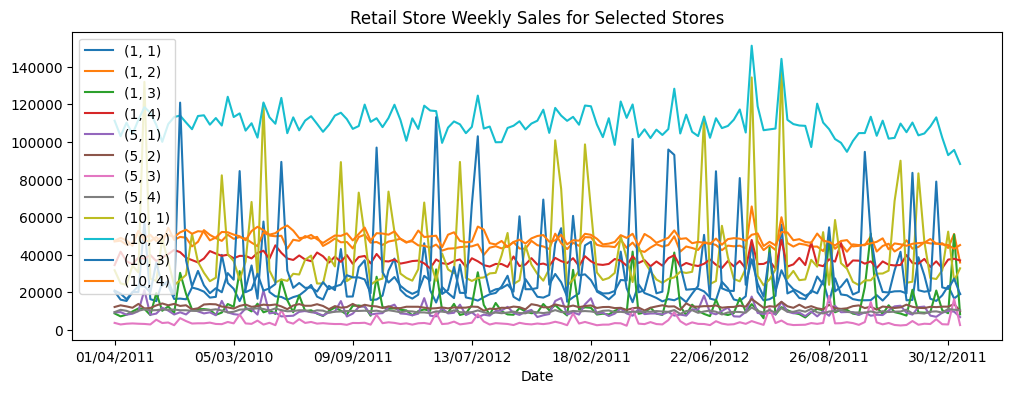

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have already created the 'storewide' DataFrame as described

# Sort the entire MultiIndex
storewide = storewide.sort_index()

# Select stores 1, 5, and 10
some_stores = storewide.loc[:, pd.IndexSlice[[1, 5, 10], [1,2,3,4]]]

# Plot the data for the selected stores
some_stores.plot(figsize=(12, 4))
plt.legend(loc='upper left')
plt.title("Retail Store Weekly Sales for Selected Stores")
plt.show()

In [18]:
len_train = int(storewide.shape[0] * 0.8)
train_data = storewide[0:len_train]
test_data = storewide[len_train:]
[train_data.shape, test_data.shape]

[(114, 3331), (29, 3331)]

In [19]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
def to_deepar_format(df, freq):
  # Reset the index to create a MultiIndex with 'Store' and 'Dept'
  data = []
  for store in df.columns.levels[0]: # Access 'Store' from the MultiIndex
        #print(store)
        for dept in df.columns.levels[1]: # Access 'Dept' from the MultiIndex
            try:
              df_subset = df[store][dept] # Select data for specific store and dept
            except KeyError:
                #print(f"Missing Dept: {dept} for Store: {store}")
                # Handle missing department for a specific store
                # Example: Impute with the average sales of other departments in the same store
                df_subset = df[store].mean(axis=1)
                # Alternatively, you could use other imputation methods or skip the missing department
            start_index = df_subset.index.min() # Access 'Date' from the DataFrame

            data.append(
                      {
                        FieldName.START:  start_index,
                        FieldName.TARGET:  df_subset.values,
                        FieldName.ITEM_ID: f"{store}_{dept}",
                     }

                    )
  #print(data)
  return ListDataset(data, freq=freq)

In [20]:
train_data_lds = to_deepar_format(train_data, 'W')
test_data_lds = to_deepar_format(test_data, 'W')

Missing Dept: 39 for Store: 1
Missing Dept: 43 for Store: 1
Missing Dept: 50 for Store: 1
Missing Dept: 65 for Store: 1
Missing Dept: 43 for Store: 2
Missing Dept: 50 for Store: 2
Missing Dept: 65 for Store: 2
Missing Dept: 37 for Store: 3
Missing Dept: 39 for Store: 3
Missing Dept: 43 for Store: 3
Missing Dept: 48 for Store: 3
Missing Dept: 50 for Store: 3
Missing Dept: 58 for Store: 3
Missing Dept: 65 for Store: 3
Missing Dept: 93 for Store: 3
Missing Dept: 99 for Store: 3
Missing Dept: 43 for Store: 4
Missing Dept: 50 for Store: 4
Missing Dept: 65 for Store: 4
Missing Dept: 37 for Store: 5
Missing Dept: 39 for Store: 5
Missing Dept: 43 for Store: 5
Missing Dept: 48 for Store: 5
Missing Dept: 50 for Store: 5
Missing Dept: 65 for Store: 5
Missing Dept: 83 for Store: 5
Missing Dept: 93 for Store: 5
Missing Dept: 99 for Store: 5
Missing Dept: 39 for Store: 6
Missing Dept: 43 for Store: 6
Missing Dept: 50 for Store: 6
Missing Dept: 65 for Store: 6
Missing Dept: 37 for Store: 7
Missing De

In [21]:
print(len(test_data_lds))
print(test_data_lds[0]['start']) # Check the start date of the first time series in your test data
print(len(test_data_lds[0]['target'])) # Check the length of the target array

3645
2011-03-21/2011-03-27
29


In [22]:
prediction_length = 11
context_length = 11
num_cells = 32
num_layers = 2
epochs= 10
freq="W"        #Frequency of the data is weekly
estimator =   DeepAREstimator(freq=freq,
                                context_length=context_length,
                                prediction_length=prediction_length,
                                num_layers=num_layers,
                                num_cells=num_cells,

                                trainer=Trainer(epochs=epochs, learning_rate=1e-2),
                               )  # For univariate time series)
predictor = estimator.train(train_data_lds)

100%|██████████| 50/50 [00:02<00:00, 19.30it/s, epoch=10/10, avg_epoch_loss=8.42]


In [23]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data_lds,#
    predictor=predictor,
    num_samples=45,  # You can adjust the number of samples as needed


)
forecasts = list(forecast_it)
tests = list(ts_it)
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) # Use the MultivariateEvaluator
# Calculate the number of unique time series based on 'ITEM_ID'


#agg_metrics, item_metrics = evaluator(iter(ts_it), iter(forecast_it))
agg_metrics, item_metrics = evaluator(tests, forecasts)
#print(len(forecasts))

Running evaluation: 3645it [00:00, 64409.77it/s]


3645


/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astyp

In [24]:
import json
print(json.dumps(agg_metrics, indent=4))
#print(item_metrics)

{
    "MSE": 27305899.549132846,
    "abs_error": 86973179.4556295,
    "abs_target_sum": 527023921.7249808,
    "abs_target_mean": 13764.158902443136,
    "seasonal_error": 4211.579296065869,
    "MASE": Infinity,
    "MAPE": 31.816076116027258,
    "sMAPE": 0.3169335175318321,
    "MSIS": Infinity,
    "QuantileLoss[0.1]": 39984399.843371466,
    "Coverage[0.1]": 0.08017206830620417,
    "QuantileLoss[0.5]": 86973179.22952583,
    "Coverage[0.5]": 0.5571723768413364,
    "QuantileLoss[0.9]": 53055922.74515787,
    "Coverage[0.9]": 0.8954479384187035,
    "RMSE": 5225.504717166835,
    "NRMSE": 0.3796457708897351,
    "ND": 0.16502700517077307,
    "wQuantileLoss[0.1]": 0.07586828262462952,
    "wQuantileLoss[0.5]": 0.16502700474175333,
    "wQuantileLoss[0.9]": 0.10067080555186692,
    "mean_absolute_QuantileLoss": 60004500.60601839,
    "mean_wQuantileLoss": 0.11385536430608327,
    "MAE_Coverage": 0.3984826461395678,
    "OWA": NaN
}


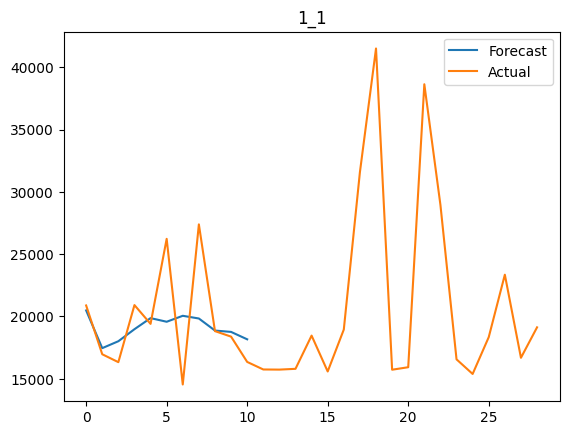

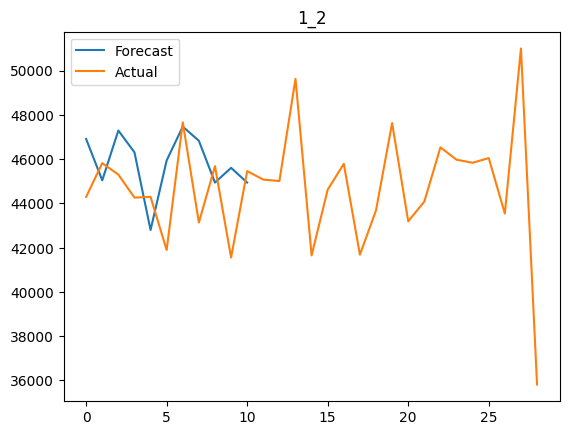

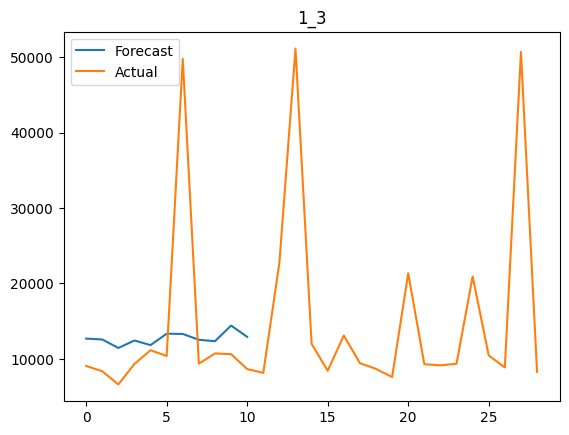

In [25]:
import numpy as np
from matplotlib import pyplot as plt

i=0
for forecast, test in zip(forecasts, tests):
    # Extract store and dept information from the test data
    i=i+1
    if i==4:
      break
    plt.plot(forecast.samples.mean(axis=0), label='Forecast')
    plt.plot(test.values, label='Actual')
    plt.title(str(forecast.item_id))  # Set title with store and dept
    plt.legend()
    plt.show()

# **Multivariate Prediction**

In [90]:
# pivot the data into the correct shape
store_multi = df_1.pivot(index='Date', columns=['Store', 'Dept'], values=['Weekly_Sales', 'CPI', 'Size', 'Fuel_Price', 'Temperature', 'Unemployment', 'IsHoliday'])
store_multi = store_multi.sort_index() # Sort the MultiIndex
#store_multi.loc[:,(('Weekly_Sales',(1,1)))]
store_multi[('IsHoliday',1,1)]

,IsHoliday
,1
,1
Date,
01/04/2011,False
01/06/2012,False
01/07/2011,False
01/10/2010,False
02/03/2012,False
...,...
30/07/2010,False


**The .values attribute returns a NumPy array. Enclosing this in a list [] creates a 2D array (a list containing a NumPy array, so if you have one colimn then do not enclose []**

In [91]:
len_multi_train = int(store_multi.shape[0] * 0.8)
train_multi_data = store_multi[0:len_multi_train]
test_multi_data = store_multi[len_multi_train:]
[train_multi_data.shape, test_multi_data.shape]

[(114, 23317), (29, 23317)]

In [94]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
def to_deepar_format(df, freq):
  # Reset the index to create a MultiIndex with 'Store' and 'Dept'
  data = []
  for store in df.columns.levels[0]: # Access 'Store' from the MultiIndex
        #print(store)
        for dept in df.columns.levels[1]: # Access 'Dept' from the MultiIndex
            try:
              df_subset = df[store][dept] # Select data for specific store and dept
            except KeyError:
                #print(f"Missing Dept: {dept} for Store: {store}")
                # Handle missing department for a specific store
                # Example: Impute with the average sales of other departments in the same store
                df_subset = df[store].mean(axis=1)
                # Alternatively, you could use other imputation methods or skip the missing department
            start_index = df_subset.index.min() # Access 'Date' from the DataFrame

            data.append(
                      {
                        FieldName.START:  start_index,
                        FieldName.TARGET:  df_subset.values,
                        FieldName.ITEM_ID: f"{store}_{dept}",
                     }

                    )
  #print(data)
  return ListDataset(data, freq=freq)
def to_deepar_format_multi(df, freq):
    data = [] # Initialize data inside the function
    for store in df.columns.levels[0]: # Access 'Store' from the MultiIndex
        #print(store)
        for dept in df.columns.levels[1]: # Access 'Dept' from the MultiIndex
            try:
              df_subset = df[store][dept] # Select data for specific store and dept
            except KeyError:
                #print(f"Missing Dept: {dept} for Store: {store}")
                # Handle missing department for a specific store
                # Example: Impute with the average sales of other departments in the same store
                df_subset = df[store].mean(axis=1)
                # Alternatively, you could use other imputation methods or skip the missing department
            start_index = df_subset.index.min()

            is_holiday = 1 if 'IsHoliday' in df_subset and df_subset["IsHoliday"].any() else 0  # Determine if there are any holidays for this store/dept combination
            # --- Handle non-numerical values in 'Size' (example: replace 'A' with 0) ---
            #df_subset['Size'] = pd.to_numeric(df_subset['Size'], errors='coerce').fillna(0)


            data.append({
                FieldName.START: start_index,
                FieldName.TARGET: df_subset["Weekly_Sales"].diff().values,  # Assuming "Weekly_Sales" is the target
                FieldName.ITEM_ID: f"{store}_{dept}",  # Add item_id
                FieldName.FEAT_STATIC_CAT: [int(store), int(dept), is_holiday],  # Store and Dept as static categorical features
    ###            #FieldName.FEAT_STATIC_CAT: [df_subset["IsHoliday"].astype(int).values],
                FieldName.FEAT_STATIC_REAL: df_subset["Size"].values,
                FieldName.FEAT_DYNAMIC_REAL: [df_subset["CPI"].values, df_subset["Fuel_Price"].values,
                                                df_subset["Temperature"].values, df_subset["Unemployment"].values]
                # Add other features as needed
            })
    #print(data) # Debugging statement
    return ListDataset(data, freq=freq)

train_data_lds = to_deepar_format_multi(train_multi_data, 'W')
test_data_lds = to_deepar_format_multi(test_multi_data, 'W')

KeyError: 'Weekly_Sales'

In [85]:
def to_deepar_format_multi(df, freq):
    data = [] # Initialize data inside the function
    for store in df.columns.levels[0]: # Access 'Store' from the MultiIndex
        #print(store)
        for dept in df.columns.levels[1]: # Access 'Dept' from the MultiIndex
            try:
                df_subset = df[store][dept] # Select data for specific store and dept
            except KeyError:
                #print(f"Missing Dept: {dept} for Store: {store}")
                # Handle missing department for a specific store
                # Example: Impute with the average sales of other departments in the same store
                df_subset = df[store].mean(axis=1)
                # Alternatively, you could use other imputation methods or skip the missing department
            start_index = df_subset.index.min()

            is_holiday = 1 if df_subset["IsHoliday"].any() else 0 # Determine if there are any holidays for this store/dept combination
            # --- Handle non-numerical values in 'Size' (example: replace 'A' with 0) ---
            #df_subset['Size'] = pd.to_numeric(df_subset['Size'], errors='coerce').fillna(0)


            data.append({
                FieldName.START: start_index,
                FieldName.TARGET: df_subset["Weekly_Sales"].diff().values,  # Assuming "Weekly_Sales" is the target
                FieldName.ITEM_ID: f"{store}_{dept}",  # Add item_id
                FieldName.FEAT_STATIC_CAT: [int(store), int(dept), is_holiday],  # Store and Dept as static categorical features
    ###            #FieldName.FEAT_STATIC_CAT: [df_subset["IsHoliday"].astype(int).values],
                FieldName.FEAT_STATIC_REAL: df_subset["Size"].values,
                FieldName.FEAT_DYNAMIC_REAL: [df_subset["CPI"].values, df_subset["Fuel_Price"].values,
                                                df_subset["Temperature"].values, df_subset["Unemployment"].values]
                # Add other features as needed
            })
    #print(data) # Debugging statement
    return ListDataset(data, freq=freq)

train_data_lds = to_deepar_format_multi(train_multi_data, 'W')
test_data_lds = to_deepar_format_multi(test_multi_data, 'W')

KeyError: 'IsHoliday'

In [83]:
for index, row in store_multi.iterrows():
    if index is None:
        print("Index is None")
    else:
      row.mean()

    #print(row['Weekly_Sales'])



In [ ]:

prediction_length = 11
context_length = 11
num_cells = 32
num_layers = 2
epochs= 50
freq="W"        #Frequency of the data is weekly
estimator =   DeepAREstimator(freq=freq,
                                context_length=context_length,
                                prediction_length=prediction_length,
                                num_layers=num_layers,
                                num_cells=num_cells,
                                cardinality=[2],
                                trainer=Trainer(epochs=epochs, learning_rate=1e-2),
                               )  # For univariate time series)
predictor = estimator.train(train_data_lds)

  0%|          | 0/50 [00:00<?, ?it/s]

In [106]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data_lds,#
    predictor=predictor,
    num_samples=45,  # You can adjust the number of samples as needed


)
foreacsts=list(forecast_it)
tests=list(ts_it)

In [104]:
from gluonts.evaluation.metrics import mse
import numpy as np



for forecast, ts in zip(forecast_it, ts_it):

    forecast_start = forecast.start_date
    prediction_length = forecast.prediction_length
    ground_truth = ts[forecast_start:forecast_start + prediction_length]
    print()
    if len(ground_truth) < prediction_length:
        # Handle the case where the ground truth is shorter than the prediction length
        # You might want to pad the ground truth or skip this prediction
        continue


    forecast_mean = np.mean(forecast.samples, axis=0)

    error = mse(np.mean(ground_truth.values), forecast_mean)
    print(f"MSE: {error}")

In [33]:
# Access the item_id for each time series in the ListDataset
item_ids = [item[FieldName.ITEM_ID] for item in test_data_lds]

# Print the item_ids
print(item_ids)

['14_91', '14_92', '14_93', '14_94', '14_95', '14_96', '14_97', '14_98', '14_1', '14_2', '14_3', '14_4', '14_5', '14_6', '14_7', '14_8', '14_9', '14_10', '14_11', '14_12', '14_13', '14_14', '14_16', '14_17', '14_18', '14_19', '14_20', '14_21', '14_22', '14_23', '14_24', '14_25', '14_26', '14_27', '14_28', '14_29', '14_30', '14_31', '14_32', '14_33', '14_34', '14_35', '14_36', '14_38', '14_40', '14_41', '14_42', '14_44', '14_46', '14_49', '14_50', '14_52', '14_54', '14_55', '14_56', '14_59', '14_60', '14_67', '14_71', '14_72', '14_74', '14_79', '14_80', '14_81', '14_82', '14_83', '14_85', '14_87', '14_90', '14_58', '14_51', '14_47', '14_99', '14_77', '15_91', '15_92', '15_93', '15_94', '15_95', '15_96', '15_97', '15_98', '15_1', '15_2', '15_3', '15_4', '15_5', '15_6', '15_7', '15_8', '15_9', '15_10', '15_11', '15_12', '15_13', '15_14', '15_16', '15_17', '15_18', '15_19', '15_20', '15_21', '15_22', '15_23', '15_24', '15_25', '15_26', '15_27', '15_28', '15_29', '15_30', '15_31', '15_32', 

In [ ]:
ground_truth.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 11 entries, 2012-08-13/2012-08-19 to 2012-10-22/2012-10-28
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       11 non-null     float32
dtypes: float32(1)
memory usage: 132.0 bytes


In [ ]:
from gluonts.evaluation import MultivariateEvaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) # Use the MultivariateEvaluator
# Calculate the number of unique time series based on 'ITEM_ID'
num_series = len({item['item_id'] for item in test_data_lds})
print(num_series  )
agg_metrics, item_metrics = evaluator(iter(ts_it), iter(forecast_it), num_series=num_series)

3216


Running evaluation:   0%|          | 0/3216 [00:00<?, ?it/s]


AssertionError: ts_iterator has more elements than fcst_iterator

#Predict

In [ ]:
pred = list(predictor.predict(test_data_lds))

In [ ]:
import numpy as np
all_preds = list()
for item in pred:

    family = item.item_id

    p = item.samples.mean(axis=0)
    p10 = np.percentile(item.samples, 10, axis=0)
    p90 = np.percentile(item.samples, 90, axis=0)
    dates = pd.date_range(start=item.start_date.to_timestamp(), periods=len(p), freq='D')
    family_pred = pd.DataFrame({'date': dates, 'family': family, 'pred': p, 'p10': p10, 'p90': p90})
    all_preds += [family_pred]
    #print(family_pred)
all_preds = pd.concat(all_preds, ignore_index=True)


In [ ]:

test_data=test[['Store','Dept','Weekly_Sales']]
test_data.reset_index(drop=False, inplace=True)
test_data.head()


,date_index,Store,Dept,Weekly_Sales
0,2012-01-06,14,91,102887.12
1,2012-01-06,14,92,206871.52
2,2012-01-06,14,93,66775.01
3,2012-01-06,14,94,61315.42
4,2012-01-06,14,95,139493.08


In [ ]:

# Split the column
all_preds[['Store', 'Dept']] = all_preds['family'].str.split('_', expand=True)
#all_preds[['date','Store','Dept','pred']]

all_preds = all_preds.rename(columns={'date': 'date_index'})
all_preds.reset_index(drop=True, inplace=True)
# Convert 'col1' to integer
all_preds['Store'] = pd.to_numeric(all_preds['Store']).astype('Int64')
all_preds['Dept'] = pd.to_numeric(all_preds['Dept']).astype('Int64')
all_preds.head()


,date_index,family,pred,p10,p90,Store,Dept
0,2012-10-29,14_91,76242.656250,70739.593750,82260.280469,14,91
1,2012-10-30,14_91,78319.062500,71278.374219,85406.428125,14,91
2,2012-10-31,14_91,73220.351562,65134.739062,82550.568750,14,91
3,2012-11-01,14_91,78519.367188,67540.550000,90277.485156,14,91
4,2012-11-02,14_91,70192.679688,60409.149609,84590.424219,14,91


In [ ]:
# Inner join on 'key' column
merged_df = pd.merge(all_preds, test_data, on=['date_index', 'Store', 'Dept'], how='inner')
merged_df = merged_df.sort_values(by=['Store', 'Dept', 'date_index'], ascending=[True, True, True])
merged_df.head()


,date_index,family,pred,p10,p90,Store,Dept,Weekly_Sales
149,2012-08-31,1_18,8572.041016,-1098.043640,18503.154688,1,18,4.97
151,2012-10-26,1_48,1962.401367,-122.065016,4749.902344,1,48,3341.00
150,2012-09-28,1_54,18.859613,-20.963015,68.531153,1,54,36.00
152,2012-08-31,2_18,17097.314453,809.877277,38999.964453,2,18,568.28
154,2012-10-26,2_48,2219.986328,38.690325,5128.227637,2,48,1420.00


In [ ]:
merged_df

,date_index,family,pred,p10,p90,Store,Dept,Weekly_Sales
149,2012-08-31,1_18,8572.041016,-1098.043640,18503.154688,1,18,4.97
151,2012-10-26,1_48,1962.401367,-122.065016,4749.902344,1,48,3341.00
150,2012-09-28,1_54,18.859613,-20.963015,68.531153,1,54,36.00
152,2012-08-31,2_18,17097.314453,809.877277,38999.964453,2,18,568.28
154,2012-10-26,2_48,2219.986328,38.690325,5128.227637,2,48,1420.00
...,...,...,...,...,...,...,...,...
144,2012-06-29,44_59,6.992718,-5.242332,18.026471,44,59,7.98
145,2012-09-28,45_18,7303.750000,-2060.036414,16593.412500,45,18,5547.95
146,2012-09-14,45_49,5.404390,-4.757350,14.657434,45,49,-6.83
147,2012-06-01,45_54,13.787907,1.686822,25.828090,45,54,5.88


In [ ]:
# prompt: Using dataframe merged_df: Plot for a store and different dept based on time_index

# Import necessary libraries
import altair as alt

# Create a chart for Store 1 and different departments
chart = alt.Chart(merged_df[merged_df.Store == 1]).mark_line().encode(
    x='date_index',
    y='Weekly_Sales',
    color='Dept'
).properties(
    title='Weekly Sales for Store 1 by Department'
)

chart


/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

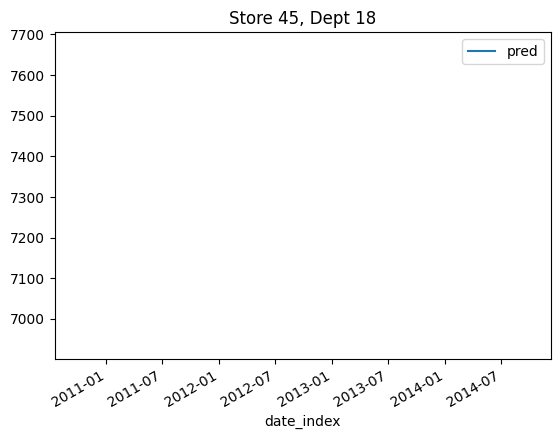

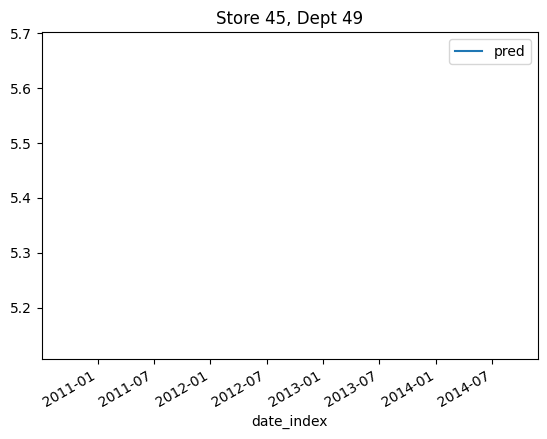

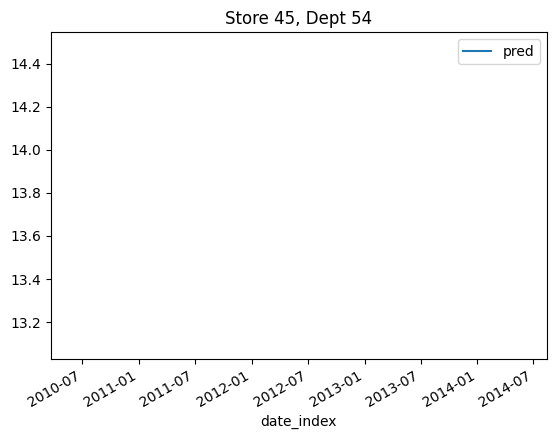

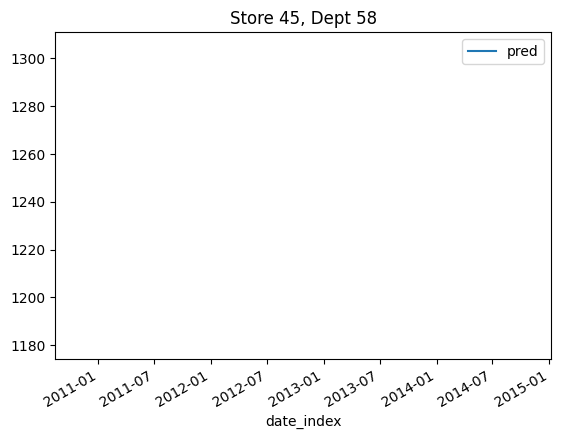

In [ ]:
# Plot 'pred' and 'Weekly_Sales'
store=45
from matplotlib import pyplot as plt
filtered_df = merged_df[merged_df['Store'] == store ]
# Iterate over each department and plot
for dept in filtered_df['Dept'].unique():
  dept_df = filtered_df[filtered_df['Dept'] == dept]
  dept_df.plot(x='date_index', y='pred', title=f"Store {store}, Dept {dept}")



In [ ]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

print(wmape(merged_df['Weekly_Sales'], merged_df['pred']))

0.8545526685388277


# Hyperparameter tuning

In [ ]:
import optuna
from gluonts.dataset.split import split
from gluonts.evaluation import Evaluator
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

def objective(trial):
    # Define hyperparameters to tune and their ranges
    num_layers = trial.suggest_int("num_layers", 1, 3)
    num_cells = trial.suggest_int("num_cells", 32, 128, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # Create estimator with trial hyperparameters
    estimator = DeepAREstimator(
        freq = 'W', # Replace with your frequency
        prediction_length = prediction_length, # Use your prediction length
        context_length = context_length, # Use your context length
        num_layers = num_layers,
        num_cells = num_cells,
        trainer = Trainer(
            epochs=10, # Consider increasing for better results
            learning_rate=learning_rate
        )
    )

    # Split data into training and validation sets
    training_data, validation_data = train_data_lds, test_data_lds

    # Train and evaluate the model
    predictor = estimator.train(training_data=training_data)

    # Generate forecasts
    forecasts = list(predictor.predict(validation_data))

    # Ensure forecasts have the correct format with 'start_date'
    # and convert predictions to pandas Series with date index
    forecasts = [
        forecast.samples.mean(axis=0)
        for forecast in forecasts
    ]
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) # Specify desired quantiles

    # Convert ListDataset to list of dictionaries for evaluation
    validation_data = list(validation_data)

    agg_metrics, item_metrics = evaluator(validation_data, forecasts)

    return agg_metrics['wQuantileLoss[0.5]'] # Optimize for quantile loss


In [ ]:
study = optuna.create_study(direction='minimize') # Minimize the objective function
study.optimize(objective, n_trials=100) # Consider increasing trials for better results

# Get best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2024-09-22 11:48:59,044] A new study created in memory with name: no-name-fe0b1b09-b569-4120-ba30-94ebcdebea4f
100%|██████████| 50/50 [00:02<00:00, 20.15it/s, epoch=10/10, avg_epoch_loss=8.17]
Running evaluation: 3216it [00:00, 33781.41it/s]
[W 2024-09-22 11:50:18,048] Trial 0 failed with parameters: {'num_layers': 1, 'num_cells': 51, 'learning_rate': 0.005024829218674721} because of the following error: TypeError("ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''").
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/local/lib/python3.10/dist-packages/gluonts/evaluation/_base.py", line 56, in worker_function
    return evaluator

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Sample time series with missing time steps
data = {'date': ['2023-01-01', '2023-01-02', '2023-01-07', '2023-01-17'],
        'value': [10, 12, 18, 22]}
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Resample to daily frequency and fill missing values with linear interpolation
df = df.resample('D').interpolate(method='slinear')

df





,value
date,
2023-01-01,10.0
2023-01-02,12.0
2023-01-03,13.2
2023-01-04,14.4
2023-01-05,15.6
2023-01-06,16.8
2023-01-07,18.0
2023-01-08,18.4
2023-01-09,18.8
